**Тема**: лінійний множиний регресійний аналіз.<br>
**Варіант**: №7 (за списком підгрупи). Дослідити країни Європи та Австралії за 2005 рік.

In [1]:
YEARS = [2005]
COUNTRIES = [
    'Albania', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
    'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'Estonia',
    'Finland', 'France', 'Georgia', 'Germany',
    'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
    'Luxembourg', 'Malta', 'Monaco', 'Montenegro', 'Netherlands', 'Norway',
    'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'San Marino',
    'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
    'The former Yugoslav republic of Macedonia', 'Ukraine', 
    'United Kingdom of Great Britain and Northern Ireland', 
] + ['Australia']

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

Крок 0. Зчитуємо дані.

In [3]:
# Монтуємо Google Drive (якщо потрібно) і зчитуємо наш csv файл як DataFrame
def is_running_in_colab():
    if hasattr(__builtins__,'__IPYTHON__'):
        return 'google.colab' in str(get_ipython())
    else:
        return False 

if is_running_in_colab():
    from google.colab import drive

    drive.mount('/content/gdrive/')
    df = pd.read_csv('/content/gdrive/MyDrive/sample_data/Life_Expectancy.csv')
else:
    df = pd.read_csv('sample_data/Life_Expectancy.csv')
  
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Крок 1. Підготовлюємо дані. Робимо зріз по країнах та роках.

In [4]:
# Чистимо пробіли в підзаголовках
df = df.rename(columns=lambda x: x.strip())

# Фільтруємо викиди за правилом 3 сігма
df[np.abs(df - df.mean()) > 3 * df.std()] = np.NaN

# Заповнюємо пусті комірки середніми значенням по колонках
df = df.fillna(df.mean())

# Фільтр для вибірки по країнам та рокам
filter = (df['Country'].isin(COUNTRIES)) & (df['Year'].isin(YEARS))

# Робимо вибірку, зріз даних по країнах і роках 
df = df[filter]

# Відкидаємо зайві колонки
df = df.drop(['Year', 'Country'], axis=1)

/tmp/ipykernel_762/3603021549.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[np.abs(df - df.mean()) > 3 * df.std()] = np.NaN
/tmp/ipykernel_762/3603021549.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df[np.abs(df - df.mean()) > 3 * df.std()] = np.NaN
/tmp/ipykernel_762/3603021549.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


Крок 2. Будуємо кореляційну матрицю.

<AxesSubplot:>

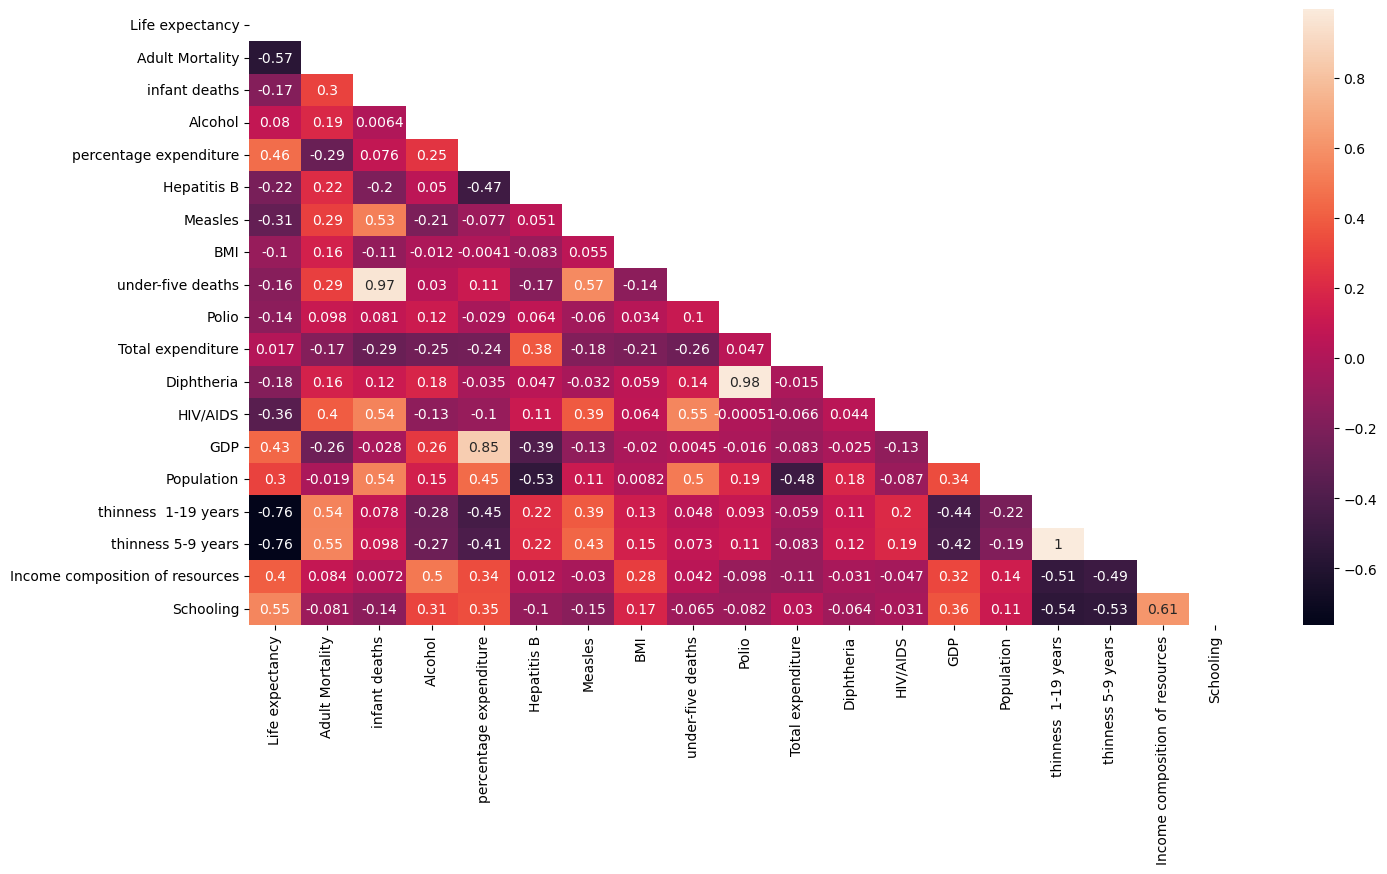

In [5]:
# Матриця кореляцій
corr = df.corr()

# Робимо маску для відображення лише нижньої діагоналі для зручності
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize = (16,8))
sns.heatmap(corr, annot=True, mask=mask)

Крок 3. Перевіряємо на мультиколініарність.

In [6]:
# Перевірка на мультиколініарність
# https://gist.github.com/anair123/66e68c33ea827cfa4cb41238404a3933#file-compute-vif

# обираємо колонки, які між собою сильно корелюють ( > 0.67 )
considered_columns = ['under-five deaths', 'infant deaths',
                      'GDP', 'percentage expenditure',
                      'Diphtheria', 'Polio',
                      'thinness  1-19 years', 'thinness 5-9 years']

# створимо функцію для обчислення коефіцієнту інфляції дисперсії.
def compute_vif(columns):
    X = df[columns]
    X['intercept'] = 1

    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# виконуємо функцію для значень які мають високу кореляцію між собою,
# відкідуючи кожного разу колонку з найвишім показником VIF, поки не залишиться
# ті колонки, в яких VIF < 5
compute_vif(considered_columns).sort_values('VIF', ascending=False)

/tmp/ipykernel_762/3779696671.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
6,thinness 1-19 years,173.931242
7,thinness 5-9 years,169.496089
4,Diphtheria,31.444521
5,Polio,31.261211
0,under-five deaths,16.622275
1,infant deaths,16.034411
3,percentage expenditure,5.044031
2,GDP,4.289439


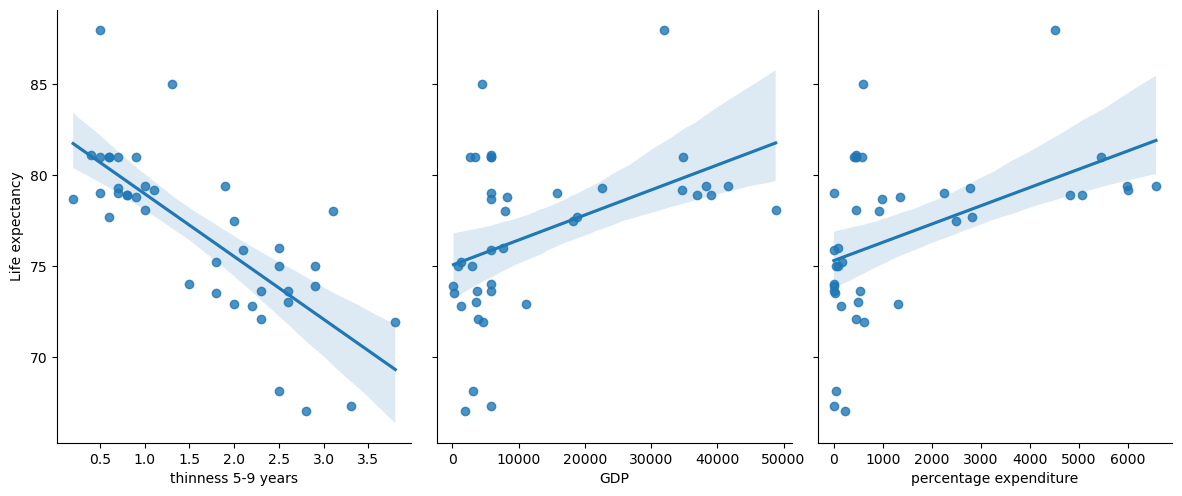

In [7]:
y_column = ['Life expectancy']
x_columns = ['thinness 5-9 years', 'GDP', 'percentage expenditure']

# Візуалізація кореляцій
sns.pairplot(df, x_vars=x_columns, y_vars=y_column, height=5, aspect=.8, kind='reg')

Крок 4. Стандартизуємо дані.

In [8]:
scaler = StandardScaler()

standardized_data = scaler.fit_transform(df[x_columns])
standardized_df = pd.DataFrame(standardized_data, columns=x_columns)

Крок 5. Для вибраних факторів (екзогенних змінних) будуємо лінійну регресійну модель:

In [9]:
x_values = standardized_df[x_columns].values
y_values = df[y_column].values

# Розділяємо на тестову та навчальні вибірки
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size = 0.25, random_state = 42)

# Створюємо обʼєкт лінійної регресії 
model = LinearRegression()
model.fit(x_train, y_train)

# Робимо прогноз
y_pred = model.predict(x_test)

Крок 6. Перевіряємо побудовану модель на точніть

In [10]:
r2 = r2_score(y_test, y_pred)

n = x_values.shape[0]
p = x_values.shape[1] - 1

adjusted_r2 = 1 - (1 - r2) * ((n - 1)/(n-p-1))
mse = mean_squared_error(y_test, y_pred)

print('Adjusted R^2 = {:.3f}'.format(adjusted_r2))
print('Mean squared error: {}'.format(np.round(mse,2)))

Adjusted R^2 = 0.656
Mean squared error: 6.87


Висновок: Дана модель не є достатньо точною. Рекомендація будувати нелінійну модель або збільшувати кількість даних.